In [1]:
import numpy as np

import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import distance
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_distances
from sklearn.manifold import TSNE

from collaborative_filter import *

### Train collaborative filtering algorithm using movie rating data 

Read data as Pandas DataFrame object

In [2]:
data = pd.read_csv("ratings.dat", sep="::", header=None, engine="python",
                   names=["userId", "itemId", "rating", "timestamp"])

In [3]:
data.shape

(1000209, 4)

In [4]:
data[:5]

,userId,itemId,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


`userId` ranges from 1 to 6040; `itemId` ranges from 1 to 3952. We'll need to preallocate `tf.Variable` for storing user and item embeddings.

In [5]:
print data["userId"].min(), data["userId"].max()
print data["itemId"].min(), data["itemId"].max()
NUM_USER, NUM_ITEM = 6040, 3952

1 6040
1 3952


In [6]:
def process_data(data):
    data[:, 0] = data[:, 0].astype(np.int32) - 1
    data[:, 1] = data[:, 1].astype(np.int32) - 1
    data[:, 2] = data[:, 2].astype(np.float32)
    return data

Preprocess data and generate training (90%) and test (10%) sets. `MiniBatchFeeder` objects are iterable such that they yield a small batch of data in each step for updating the values of `tf.Variable` objects.

In [7]:
data = process_data(data.values)

train, test = train_test_split(data, test_size=0.1, random_state=42)

feeder_train = MiniBatchFeeder(train, shuffle_data=True)
feeder_test = MiniBatchFeeder(test, shuffle_data=False)


Create and fit `CollaborativeFilter` object. `feeder_train` is used for training, and `feeder_test` is used to monitor the error on the test set.

In [8]:
cf = CollaborativeFilter(tf.truncated_normal_initializer(stddev=0.02), NUM_USER, NUM_ITEM, num_epoch=100)
cf.fit(feeder_train, feeder_test)

Plot RMSE on the training and test sets as a function of training epochs:

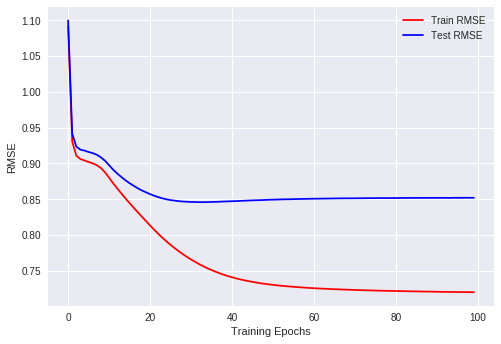

In [9]:
plt.plot(cf.log_rmse_["train_rmse"], color="r")

plt.plot(cf.log_rmse_["test_rmse"], color="b")
plt.legend(["Train RMSE", "Test RMSE"])
plt.ylabel("RMSE")
plt.xlabel("Training Epochs")
plt.show()

Training RMSE is monotonically decreassing and lies below test RMSE. Test RMSE monotonically decreases in approximately the first 30 epochs, then it starts to slowly increase.

### Movie embeddings

In the latent model based collaborative filtering algorithm, each user and item has a vector representation (aka embedding). In the MovieLens dataset, movies come with some descriptive information, such as the genre and title. So we can utilize these data to verify whether the movie embeddings make sense or not.

Specifically, we'll find the number of overlapping genre types for each pair of movies, and then compute the distance between the movie embeddings. Ideally, the bigger the overlap, the closer the embedding vector should be.

For this purpose, we'll train the collabrative filering algorithm using the entire data:

In [10]:
feeder_data = MiniBatchFeeder(data, shuffle_data=True)

In [11]:
cf = CollaborativeFilter(tf.truncated_normal_initializer(stddev=0.02), NUM_USER, NUM_ITEM, num_epoch=30)
cf.fit(feeder_data)

In [12]:
movies = pd.read_csv("movies.dat", sep="::", header=None, engine="python", names=["id", "title", "genres"])
movies["id"] = movies["id"] - 1
movies["genres"] = movies["genres"].map(lambda x: x.split("|"))

movies["embd"] = movies["id"].map(lambda x: cf.embds_["embd_item"][x, :]) # map movie embeddings to each row

In [13]:
movies[-5:]

,id,title,genres,embd
3878,3947,Meet the Parents (2000),[Comedy],"[0.112725, 0.0136472, -0.216971, -0.364964, 0...."
3879,3948,Requiem for a Dream (2000),[Drama],"[0.307094, 0.378372, 0.058386, -0.345265, -0.4..."
3880,3949,Tigerland (2000),[Drama],"[-0.320893, 0.273504, 0.29828, 0.358911, -0.03..."
3881,3950,Two Family House (2000),[Drama],"[0.0283635, 0.506468, 0.089395, -0.101404, -0...."
3882,3951,"Contender, The (2000)","[Drama, Thriller]","[0.310367, 0.220448, -0.132592, 0.054874, -0.0..."


Compute the number of shared genre types and cosine similarity of embeddings for each pair of movies:

In [14]:
df = [(len(set(movies.iat[i, 2]) & set(movies.iat[j, 2])),
       1 - distance.cosine(movies.iat[i, 3], movies.iat[j, 3]))
       for i in range(len(movies) - 1) for j in range(i + 1, len(movies))]

For each value of `"Num of shared genre types"` compute the average of cosine similarities:

In [15]:
df = pd.DataFrame(df, columns=["overlap", "cosine similarity"])
df = df.groupby("overlap").mean()

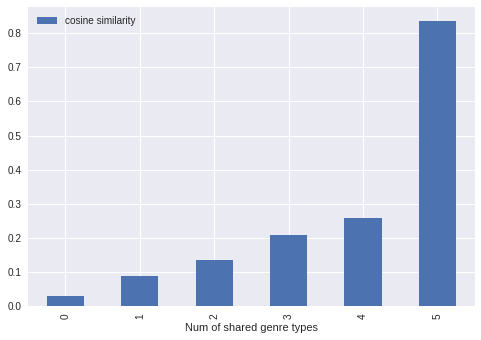

In [16]:
df.plot(kind="bar")
plt.xlabel("Num of shared genre types")
plt.show()

As we can see the pairwise cosine similarity of movie embeddings increases with the number of shared genres types, which makes sense.

In [17]:
users = pd.read_csv("users.dat", header=None, sep="::", engine="python", names=["id", "gender", "age", "occupation", "zip"])
users["id"] = users["id"] - 1
users["embd"] = users["id"].map(lambda x: cf.embds_["embd_user"][x, :]) # map user embeddings to each row

### User embeddings

Just like movies, the users in the MovieLens dataset contain some descriptive info, such as *gender*, *age*, *occupation*. Here is a sample of users:

In [18]:
users[:5]

,id,gender,age,occupation,zip,embd
0,0,F,1,10,48067,"[0.0393548, -0.0607581, 0.337178, 0.255432, 0...."
1,1,M,56,16,70072,"[-0.125107, 0.152737, 0.203534, 0.212588, -0.1..."
2,2,M,25,15,55117,"[-0.0390642, 0.283527, 0.00183151, -0.413988, ..."
3,3,M,45,7,02460,"[-0.129919, 0.303546, -0.163082, 0.515275, 0.1..."
4,4,M,25,20,55455,"[-0.402048, 0.0508262, -0.450231, 0.091535, 0...."


The string values for `age` and `occupation` index values are as follows:

In [19]:
age_map = {1: "Under 18",
           18: "18-24",
           25: "25-34",
           35: "35-44",
           45: "45-49",
           50: "50-55",
           56: "56+"}

occupation_map = {0: "other",
                  1: "academic/educator",
                  2: "artist",
                  3: "clerical/admin",
                  4: "college/grad student",
                  5: "customer service",
                  6: "doctor/health care",
                  7: "executive/managerial",
                  8: "farmer",
                  9: "homemaker",
                  10: "K-12 student",
                  11: "lawyer",
                  12: "programmer",
                  13: "retired",
                  14: "sales/marketing",
                  15: "scientist",
                  16: "self-employed",
                  17: "technician/engineer",
                  18: "tradesman/craftsman",
                  19: "unemployed",
                  20: "writer"}

age_map = pd.Series(age_map)
occupation_map = pd.Series(occupation_map)

The value distribution for `gender`, `age` and `occupation` columns are as follows:

In [20]:
users["gender"].value_counts()

M    4331
F    1709
Name: gender, dtype: int64

In [21]:
users["age"].value_counts()

25    2096
35    1193
18    1103
45     550
50     496
56     380
1      222
Name: age, dtype: int64

In [22]:
users["occupation"].value_counts()

4     759
0     711
7     679
1     528
17    502
12    388
14    302
20    281
2     267
16    241
6     236
10    195
3     173
15    144
13    142
11    129
5     112
9      92
19     72
18     70
8      17
Name: occupation, dtype: int64

Because each users contains some descriptive data and has a vector representation, we can plot them in 2D and see how users with different group categories (e.g. male and female) are distributed.

First we need a matrix `X` storing all user embeddings:

In [23]:
X = np.array([v for v in users["embd"]])
X.shape

(6040, 20)

To plot them in 2D space, we applied TSNE for dimensionality reduction:

In [24]:
tsne = TSNE(n_components=2, random_state=100)
X_tsne = tsne.fit_transform(X)

We'll label male and female users with different colors:

In [25]:
m_index = (users["gender"] == "M").values
f_index = (users["gender"] == "F").values

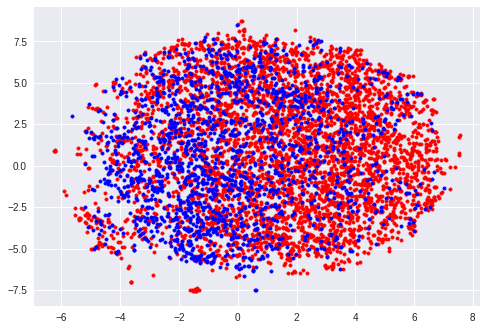

In [26]:
plt.scatter(X_tsne[m_index, 0], X_tsne[m_index, 1], c="r", marker=".")
plt.scatter(X_tsne[f_index, 0], X_tsne[f_index, 1], c="b", marker=".")
plt.show()

It seems like blue dots(female) are denser in the left half, while red dots (male) are denser in the right half.

To quantitatively verify, we can compute the centers of red and blue dots separately, and compute distance of each dot (red or blue) with respect to the two centers:

In [27]:
X_m_center = X[m_index].mean(axis=0)
X_f_center = X[f_index].mean(axis=0)

In [28]:
d_mm = np.array([distance.cosine(X[m_index][i, :], X_m_center) for i in range(X[m_index].shape[0])])
d_mf = np.array([distance.cosine(X[m_index][i, :], X_f_center) for i in range(X[m_index].shape[0])])

In [29]:
print "mean(dist(M_user, M_center))=%.4f, mean(dist(M_user, F_center))=%.4f" % (d_mm.mean(), d_mf.mean())

mean(dist(M_user, M_center))=0.7125, mean(dist(M_user, F_center))=0.8177


In [30]:
d_fm = np.array([distance.cosine(X[f_index][i, :], X_m_center) for i in range(X[f_index].shape[0])])
d_ff = np.array([distance.cosine(X[f_index][i, :], X_f_center) for i in range(X[f_index].shape[0])])

In [31]:
print "mean(dist(F_user, M_center))=%.4f, mean(dist(F_user, F_center))=%.4f" % (d_fm.mean(), d_ff.mean())

mean(dist(F_user, M_center))=0.7796, mean(dist(F_user, F_center))=0.6575


As we can see, male users are generally closer to male center than to the female center, and female users are closer to femal center than to the male center.

So **male female users seem to have generally different tastes and preferences** for movies.

`gender` column has only two categories, while `age` and `occupation` has more. We can think of users within different `age` and `occupation` groups as clusters. By measuring the inter-cluster distance (aka linkage criterion), we can have some idea of how far apart (or close-by) different clusters of users are.

For simplicity we choose the average pairwise distance metric as the linkage criterion. We could also try more robust linkage criterion such as [*Ward*](https://en.wikipedia.org/wiki/Ward%27s_method).

This helper function `group_heatmap` computes a $n\times n$ matrix containing the linkage criterion over all pairs user clusters (for `age` and `occupation`). We use cosine dissimilarity as the distance metric for individual data point.

In [32]:
def group_heatmap(group_map, col_name):

    def group_distance(id1, id2, col_name):
        def average_linkage(X1, X2):
            return cosine_distances(X1, X2).mean()
    
        col = users[col_name]
        index1 = (col==id1).values
        index2 = (col==id2).values
        X1 = X[index1]
        X2 = X[index2]
    
        return average_linkage(X1, X2)

    ids = sorted(group_map.keys())
    names = [group_map[i] for i in ids]
    
    df = np.zeros((len(ids), len(ids)))

    for i in range(len(ids)):
        for j in range(len(ids)):
            df[i, j] = group_distance(ids[i], ids[j], col_name) 
    
    df = pd.DataFrame(df, columns=names, index=names)
    return df

#### 1. Pairwise linkage criterion for **age**:

In [33]:
df = group_heatmap(age_map, "age")

In [34]:
df.applymap(lambda x: "%.4f" % x)

,Under 18,18-24,25-34,35-44,45-49,50-55,56+
Under 18,0.9252,0.9249,0.9536,0.9702,0.9773,0.9789,0.9721
18-24,0.9249,0.8808,0.9059,0.9487,0.9685,0.9679,0.9647
25-34,0.9536,0.9059,0.8951,0.9218,0.9378,0.9335,0.9356
35-44,0.9702,0.9487,0.9218,0.9135,0.9116,0.9047,0.9045
45-49,0.9773,0.9685,0.9378,0.9116,0.8972,0.8883,0.8841
50-55,0.9789,0.9679,0.9335,0.9047,0.8883,0.8766,0.8723
56+,0.9721,0.9647,0.9356,0.9045,0.8841,0.8723,0.8530


In [35]:
%matplotlib inline

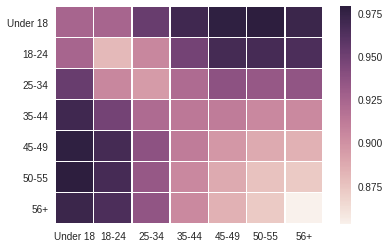

In [36]:
sns.heatmap(df, linewidths=0.5)
plt.show()

In [37]:
%matplotlib auto

Using matplotlib backend: Qt5Agg


As we can see, the linkage criterion between different age groups seems to correlate with the gap in age. For example, for users *"Under 18"*, the distance of other age groups with respect to *"Under 18"* seems to grow monotonically with the age. The different age groups almost form a *"spectrum"*, with *"Under 18"* and *56+* being the poles.

It's also interesting to see that older users (*35-44*, *45-49*, *50-55*, *56+*) seem to have lower inter-group distance than younger users (i.e. the lighter color in the bottom right), while *Under 18* seem to have different tastes for movies than other age group.

#### 2. Pairwise linkage criterion for **occupation**:

In [38]:
df = group_heatmap(occupation_map, "occupation")

In [39]:
%matplotlib inline

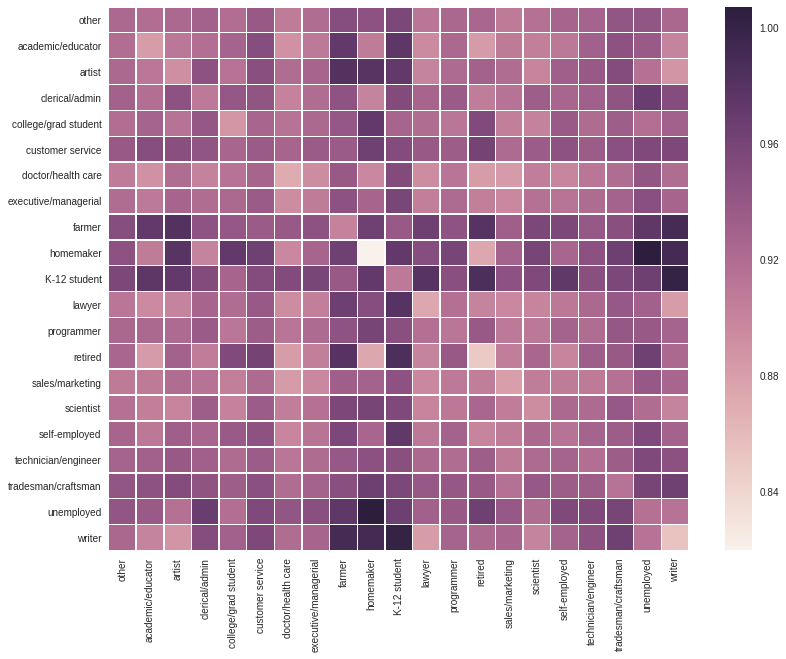

In [40]:
pylab.rcParams['figure.figsize'] = (13.0, 10.0)

sns.heatmap(df, linewidths=0.5)
plt.show()

In [41]:
%matplotlib auto

Using matplotlib backend: Qt5Agg


We can also compute the average inter-group distance for each occupation group. That is, for each row, compute the average over all columns excluding the diagonal entry (i.e. the same group):

In [42]:
((df.sum(axis=1) - np.diag(df))/20).sort_values(ascending=False)

K-12 student            0.961144
farmer                  0.955030
unemployed              0.947534
homemaker               0.947122
customer service        0.942743
tradesman/craftsman     0.942417
writer                  0.934814
clerical/admin          0.931764
artist                  0.931259
technician/engineer     0.931200
programmer              0.928554
self-employed           0.928240
other                   0.927943
college/grad student    0.926986
retired                 0.925623
executive/managerial    0.922204
scientist               0.921547
academic/educator       0.921032
lawyer                  0.919479
sales/marketing         0.914185
doctor/health care      0.910624
dtype: float64

As we can see, *K-12 student*, *farmer* and *homemaker* seem to have very different tastes than other groups (note the darker stripes). For *K-12 students*, this would be very understandable, because they are the only non-adult group, and what they might like (e.g. aminations, children's movie) would be unlikely liked by other users.

Finally, let's take a look at what are the most similar and dissimilar pairs of occupation groups:

In [46]:
triple = [(i, j, df.iat[i, j]) for i in range(len(df) - 1) for j in range(i + 1, len(df))]
triple = pd.DataFrame(triple, columns=["i", "j", "dist"])
triple = triple.sort_values("dist", ascending=True)

In [47]:
# Most similar occupation groups
pd.concat([triple[:10]["i"].map(lambda i: occupation_map[i]),
           triple[:10]["j"].map(lambda j: occupation_map[j]),
           triple[:10]["dist"]], axis=1)

,i,j,dist
147,homemaker,retired,0.873217
173,lawyer,writer,0.881223
111,doctor/health care,retired,0.881594
31,academic/educator,retired,0.882045
112,doctor/health care,sales/marketing,0.883220
56,artist,writer,0.887284
24,academic/educator,doctor/health care,0.889370
105,doctor/health care,executive/managerial,0.893086
109,doctor/health care,lawyer,0.893770
29,academic/educator,lawyer,0.895585


In [48]:
# Most dissimilar occupation groups
pd.concat([triple[-1:-11:-1]["i"].map(lambda i: occupation_map[i]),
           triple[-1:-11:-1]["j"].map(lambda j: occupation_map[j]),
           triple[-1:-11:-1]["dist"]], axis=1)

,i,j,dist
153,homemaker,unemployed,1.007051
164,K-12 student,writer,1.001158
154,homemaker,writer,0.991488
143,farmer,writer,0.990000
157,K-12 student,retired,0.985307
44,artist,farmer,0.981703
155,K-12 student,lawyer,0.980132
136,farmer,retired,0.980004
45,artist,homemaker,0.979714
28,academic/educator,K-12 student,0.976269


### Number of dimensions of movie and user embeddings

Note that we trained the collaborative filter by setting `num_dims` to 20. We can vary the number of dimensions to see the its impact on the training accuracy. We'll plot the RMSE on the test set as a function of training epochs for different values of `num_dims`:

In [49]:
rmse_dims = []

for num_dim in [10, 20, 30, 40]:
    print num_dim
    cf = CollaborativeFilter(tf.truncated_normal_initializer(stddev=0.02), NUM_USER, NUM_ITEM, num_epoch=100, num_dim=num_dim)
    cf.fit(feeder_train, feeder_test)
    rmse_dims.append(cf.log_rmse_["test_rmse"])

10
20
30
40


In [50]:
rmse_dims = np.array(rmse_dims)
rmse_dims.shape

(4, 100)

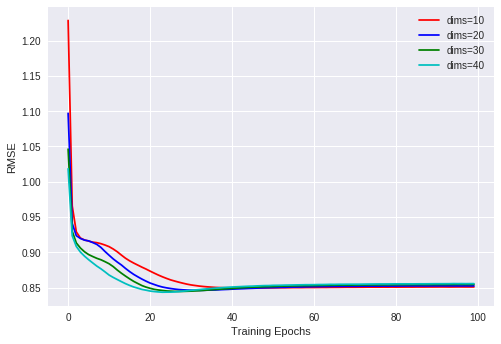

In [52]:
for i, c in enumerate(["r", "b", "g", "c"]):
    plt.plot(rmse_dims[i, :], color=c)
    
plt.legend(["dims=10", "dims=20", "dims=30", "dims=40"])
plt.ylabel("RMSE")
plt.xlabel("Training Epochs")
plt.show()

As we can see, in the earlier stage of training, models with higher dimensions seems to have an advantage over those with lower dimensions. But this advantage quickly disappears when the RMSE plateaus.